In [48]:
import os
import configparser

# Loading configurations
configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)

insert_amd_env_vars =  int(configParser.get('COMMON', 'insert_amd_env_vars'))
HSA_OVERRIDE_GFX_VERSION =  configParser.get('COMMON', 'HSA_OVERRIDE_GFX_VERSION')
ROCM_PATH =  configParser.get('COMMON', 'ROCM_PATH')

if(insert_amd_env_vars != 0):
    os.environ["HSA_OVERRIDE_GFX_VERSION"] = HSA_OVERRIDE_GFX_VERSION
    os.environ["ROCM_PATH"] = ROCM_PATH
    
#import os
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
#os.environ["AUTOGRAPH_VERBOSITY"] = "0"

In [49]:

import configparser

# Loading configurations
configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)


datasetPathGeneratedFaces =  configParser.get('evaluate_imagen', 'test_datasetPathGeneratedFaces')
generated_face_table_name =  configParser.get('evaluate_imagen', 'generated_face_table_name')
evaluation_results_folder = configParser.get('evaluate_imagen', 'evaluation_results_folder')
datasetPathFaces =  configParser.get('evaluate_imagen', 'test_datasetpathfaces')

datasetPathGeneratedFaces_pooled =  configParser.get('evaluate_imagen', 'test_datasetpathgeneratedfaces_pooled')
datasetPathFaces_pooled =  configParser.get('evaluate_imagen', 'test_datasetpathfaces_pooled')

datasetPathDatabase =  configParser.get('COMMON', 'test_datasetPathDatabase') + '/dataset.db'



cuda =  int(configParser.get('COMMON', 'cuda'))
cpus =  int(configParser.get('COMMON', 'cpus'))




In [3]:
#TODO document jupyter
import pickle
import sqlite3 as sl
import pandas as pd
import numpy as np
from PIL import Image

from textwrap import wrap
import os


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [4]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None


In [5]:
image_size =  int(configParser.get('COMMON', 'resizeImageTo'))
audio_length_used =  configParser.get('evaluate_imagen', 'audio_length_used') 
model_filename =  configParser.get('evaluate_imagen', 'model_filename') + '_'  + audio_length_used +  's.pt'
openl3_mode =  configParser.get('evaluate_imagen', 'openl3_mode')

In [6]:
import lancedb
uri = datasetPathDatabase
db = lancedb.connect(uri)

table_generated = db.open_table(generated_face_table_name).to_pandas()
table_generated


,id,id_true,generated_face_path,user
0,0,0,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00017
1,1,183,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00061
2,2,471,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00081
3,3,780,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00154
4,4,968,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00419
5,5,1468,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00812
6,6,1875,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00817
7,7,2328,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00866
8,8,2600,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00926
9,9,2763,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id01000


In [7]:
try:
  db.drop_table(generated_face_table_name)
except:
  print("")

In [8]:
import multiprocessing
try:
    multiprocessing.set_start_method('spawn')
except:
    print("")

In [9]:
import pathlib
import os
from random import randrange


uri = datasetPathDatabase
db = lancedb.connect(uri)





In [10]:
audio_folder = output_folder = r'imagen_testing_folder' 
if not os.path.exists(audio_folder):
    os.makedirs(audio_folder)

In [11]:

from testing_imagen_vision_transformer import extract_vision_transformer
from testing_imagen_face import extract_face_rep,extract_face_attributes
import pathlib
import shutil


2023-10-13 15:30:35.689770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:


i = 0
for index, row in table_generated.iterrows():
    face_file = row['generated_face_path']
    user = row['user']
    id_true= int(row['id_true'])

    
    q = multiprocessing.Queue()

    try:
        proc = multiprocessing.Process(target=extract_face_rep, args=(q,face_file,
                                                                image_size,output_folder,))
        proc.start()
        proc.join()
    except:
        continue

    with open(output_folder + '/' + 'vgg_generated_face.pickle', 'rb') as handle:
        vgg = pickle.load(handle)
        #print("++++++" + str(vgg))

    try:
        proc = multiprocessing.Process(target=extract_face_attributes, args=(q,face_file,))
        proc.start()
        proc.join()

        gender = q.get()
        if(gender == 'Error'):
            continue
        ethnicity = q.get()
        if(ethnicity == 'Error'):
            continue
        age = q.get()
        if(age == 'Error'):
            continue

    except:
        continue


    
    tbl = db.open_table("video_stage1")
    result = tbl.search(vgg).limit(10).to_df()

    match_1 = result.iloc[0]['user']
    match_2 = result.iloc[1]['user']
    match_3 = result.iloc[2]['user']
    match_4 = result.iloc[3]['user']
    match_5 = result.iloc[4]['user']
    match_6 = result.iloc[5]['user']
    match_7 = result.iloc[6]['user']
    match_8 = result.iloc[7]['user']
    match_9 = result.iloc[8]['user']
    match_10= result.iloc[9]['user']
    

    df_table = pd.DataFrame()
    df_table = df_table.append({'id': i , 'id_true':id_true,
                    'generated_face_path': face_file,'user':user,'age':age,'gender':gender,'ethnicity':ethnicity,
                    'match_1':match_1,'match_2':match_2,'match_3':match_3,'match_4':match_4,'match_5':match_5,
                    'match_6':match_6,'match_7':match_7,'match_8':match_8,'match_9':match_9,'match_10':match_10,
        'vector' : vgg,'stage': 1}, ignore_index=True)
    

    if(i == 0):
        try:
            db.create_table(generated_face_table_name, df_table)
        except:
            db.drop_table(generated_face_table_name)
            db.create_table(generated_face_table_name, df_table)
    else:
        tbl = db.open_table(generated_face_table_name)
        tbl.add(df_table)


    print("---------------" + str(i) + "----------------")
    i = i + 1

shutil.rmtree(output_folder)


Action: race: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]  


---------------0----------------


Action: race: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]  


---------------1----------------


Action: race: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]  


---------------2----------------


Action: race: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]  


---------------3----------------


Action: race: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]  


---------------4----------------


Action: race: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]  


---------------5----------------


Action: race: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]  


---------------6----------------


Action: race: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]  


---------------7----------------


Action: race: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]  


---------------8----------------


Action: race: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]  


---------------9----------------


Action: race: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]  


---------------10----------------


In [13]:
tbl = db.open_table(generated_face_table_name)

In [14]:
ptable = tbl.to_pandas()
ptable

,id,id_true,generated_face_path,user,age,gender,ethnicity,match_1,match_2,match_3,match_4,match_5,match_6,match_7,match_8,match_9,match_10,vector,stage
0,0,0,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00017,34,Man,asian,id00812,id00154,id00817,id00061,id00419,id00866,id00017,id00926,id01000,id00081,"[0.0075060795, 0.0031019482, 0.002376909, 0.00...",1
1,1,183,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00061,35,Man,asian,id00812,id00154,id00817,id00061,id00419,id00866,id00017,id00926,id01000,id00081,"[0.0076998365, 0.0036566316, 0.0028854471, 0.0...",1
2,2,471,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00081,36,Man,middle eastern,id00812,id00154,id00061,id00817,id00419,id00866,id00017,id00926,id01000,id00081,"[0.0078802565, 0.0033581466, 0.0025512753, 0.0...",1
3,3,780,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00154,37,Man,asian,id00812,id00154,id00817,id00061,id00419,id00866,id00017,id00926,id01000,id00081,"[0.0072413436, 0.0031869488, 0.0024481025, 0.0...",1
4,4,968,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00419,36,Man,asian,id00812,id00154,id00817,id00061,id00419,id00866,id00017,id00926,id01000,id00081,"[0.0068007736, 0.0025085332, 0.003274194, 0.00...",1
5,5,1468,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00812,36,Man,asian,id00812,id00154,id00817,id00061,id00419,id00866,id00017,id00926,id01000,id00081,"[0.0067802374, 0.0026269024, 0.0026200695, 0.0...",1
6,6,1875,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00817,36,Man,asian,id00812,id00154,id00817,id00061,id00419,id00866,id00017,id00926,id01000,id00081,"[0.007610667, 0.0026419596, 0.0026976238, 0.00...",1
7,7,2328,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00866,34,Man,asian,id00812,id00154,id00817,id00061,id00419,id00866,id00017,id00926,id01000,id00081,"[0.006814258, 0.0025084624, 0.0028836415, 0.00...",1
8,8,2600,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id00926,33,Man,asian,id00812,id00154,id00817,id00061,id00419,id00866,id00017,id00926,id01000,id00081,"[0.0075222575, 0.0028506285, 0.0030971956, 0.0...",1
9,9,2763,/media/gamal/Passport/Datasets/VoxCeleb2TestMi...,id01000,31,Man,asian,id00812,id00154,id00061,id00817,id00419,id00866,id00017,id00926,id01000,id00081,"[0.007852313, 0.0037854768, 0.002530039, 0.007...",1


In [128]:
ptable_unique_users = ptable.drop_duplicates(subset=['user'], keep='first')

In [129]:
f= open(evaluation_results_folder + "/results.txt","w+")
f.write("No. of generated faces: " + str(len(ptable)) + "\n")
f.write("No. of unique users: " + str(len(ptable_unique_users)) + "\n")


24

In [130]:
acc_10 = int((len(tbl.search() \
   .where(""" user = match_1 or user = match_2 or user = match_3 
          or user = match_4 or user = match_5 or user = match_6 or user = match_7
          or user = match_8 or user = match_9 or user = match_10
    """).to_df()) / float(len(ptable))) * 100)
f.write("Face Recognition Accuracy within first 10 matches: " + str(acc_10) + "%\n")


56

In [131]:
acc_5 = int((len(tbl.search() \
   .where(""" user = match_1 or user = match_2 or user = match_3
          or user = match_4 or user = match_5 
    """).to_df()) / float(len(ptable))) * 100)
f.write("Face Recognition Accuracy within first  5 matches: " + str(acc_5) + "%\n")

55

In [132]:
acc_3 = int((len(tbl.search() \
   .where(""" user = match_1 or user = match_2 or user = match_3
    """).to_df()) / float(len(ptable))) * 100)
f.write("Face Recognition Accuracy within first  3 matches: " + str(acc_3) + "%\n")

55

In [133]:
acc_1 = int((len(tbl.search() \
   .where(""" user = match_1
    """).to_df()) / float(len(ptable))) * 100)
f.write("Face Recognition Accuracy within first  1 matches: " + str(acc_1) + "%\n")

55

In [134]:
tbl_generated = db.open_table(generated_face_table_name)
tbl_truth = db.open_table("video_stage1")

In [135]:
pandas_generated = tbl_generated.to_pandas()
pandas_users = pandas_generated[['id_true','user']]
#pandas_users = pandas_users.drop_duplicates(keep='first', inplace=False)
pandas_users["age_true"] = np.nan
pandas_users["age_generated"] = np.nan
pandas_users["gender_true"] = np.nan
pandas_users["gender_generated"] = np.nan
pandas_users["ethnicity_true"] = np.nan
pandas_users["ethnicity_generated"] = np.nan
pandas_users

,id_true,user,age_true,age_generated,gender_true,gender_generated,ethnicity_true,ethnicity_generated
0,0,id00017,NaN,NaN,NaN,NaN,NaN,NaN
1,183,id00061,NaN,NaN,NaN,NaN,NaN,NaN
2,471,id00081,NaN,NaN,NaN,NaN,NaN,NaN
3,780,id00154,NaN,NaN,NaN,NaN,NaN,NaN
4,968,id00419,NaN,NaN,NaN,NaN,NaN,NaN
5,1468,id00812,NaN,NaN,NaN,NaN,NaN,NaN
6,1875,id00817,NaN,NaN,NaN,NaN,NaN,NaN
7,2328,id00866,NaN,NaN,NaN,NaN,NaN,NaN
8,2600,id00926,NaN,NaN,NaN,NaN,NaN,NaN
9,2763,id01000,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def make_square(im, min_size=image_size, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    im.close()
    return new_im

def real_image_preprocess(path):

    image = Image.open(path).convert('RGB')

    w_s = image_size / (1+2 * 0.5)
    h_s = image_size / (1+2 * 0.4)

    image = image.crop((0.4*w_s, 0.0*h_s, 1.6*w_s, 1.4*h_s))

    image = make_square(image)

    image = image.resize((begin_with_image_size,begin_with_image_size))
    im = image
    

    #print('saving')
    #image.save('opop.png')

    #print(np.array(image,np.float32).shape)

    pix = np.array(image, np.float32)
    pix = np.moveaxis(pix, -1, 0)

    pix = pix / 255
    image.close()
    im.close()
    return pix.tolist()
return image_guide

In [24]:
import cv2
from skimage.metrics import structural_similarity as calc_ssim
from skimage.metrics import mean_squared_error
psnr = []
ssim = []
mse = []
for index, row in pandas_users.iterrows():
    id_true = str(row['id_true'])
    user = row['user']
    user = "'" + user + "'"
    m = tbl_truth.search().where(" id = " + id_true).to_df()
    
    pandas_users.loc[index,'age_true'] = m['age'][0]
    pandas_users.loc[index,'gender_true'] = m['gender'][0]
    pandas_users.loc[index,'ethnicity_true'] = m['ethnicity'][0]

    n = tbl_generated.search().where(" id_true = " + id_true).to_df()
    pandas_users.loc[index,'age_generated'] = n['age'][0]
    pandas_users.loc[index,'gender_generated'] = n['gender'][0]
    pandas_users.loc[index,'ethnicity_generated'] = n['ethnicity'][0]


    print("real: " + m['face_path'][0])
    print("generated: " + n['generated_face_path'][0])

    
    im_true = cv2.imread(m['face_path'][0])
    im_generated = cv2.imread(n['generated_face_path'][0])
    psnr.append(cv2.PSNR(im_true, im_generated))
    #print(im_true.shape)
    ssim.append(calc_ssim(im_true,im_generated,channel_axis=2))

    mse.append(mean_squared_error(im_true,im_generated))
    

    

real: /home/gamal/Datasets/Dataset1Test/FacesTest/id00002/obama/obama_face_1.png
generated: /home/gamal/Datasets/Dataset1Test/GeneratedFacesTest/id00002/obama/obama_generated_face_.png
real: /home/gamal/Datasets/Dataset1Test/FacesTest/id00001/trump/trump_face_1.png
generated: /home/gamal/Datasets/Dataset1Test/GeneratedFacesTest/id00001/trump/trump_generated_face_.png
real: /home/gamal/Datasets/Dataset1Test/FacesTest/id00006/afsd/0qIAk5sTwEo_173.333333_176.333333_face_1.png
generated: /home/gamal/Datasets/Dataset1Test/GeneratedFacesTest/id00006/afsd/0qIAk5sTwEo_173.333333_176.333333_generated_face_.png
real: /home/gamal/Datasets/Dataset1Test/FacesTest/id00008/sadf/1uizi6R-PMU_116.920000_120.000000_face_1.png
generated: /home/gamal/Datasets/Dataset1Test/GeneratedFacesTest/id00008/sadf/1uizi6R-PMU_116.920000_120.000000_generated_face_.png
real: /home/gamal/Datasets/Dataset1Test/FacesTest/id00010/asdf/-6Q8rfdxYoM_197.600000_204.200000_face_1.png
generated: /home/gamal/Datasets/Dataset1Test

In [137]:
f.write('Average PSNR is: ' + str(np.array(psnr).mean()) + "\n")
f.write('Average SSIM is: ' + str(np.array(ssim).mean()) + "\n")
f.write('Average  MSE is: ' + str(np.array(mse).mean()) + "\n")

35

In [138]:
from math import sqrt
age_true = pandas_users['age_true'].to_numpy()
age_generated = pandas_users['age_generated'].to_numpy()
age_rmse = sqrt(((age_true - age_generated)**2).mean(axis = 0))
f.write('rmse of age: ' + str(age_rmse) + "\n")

31

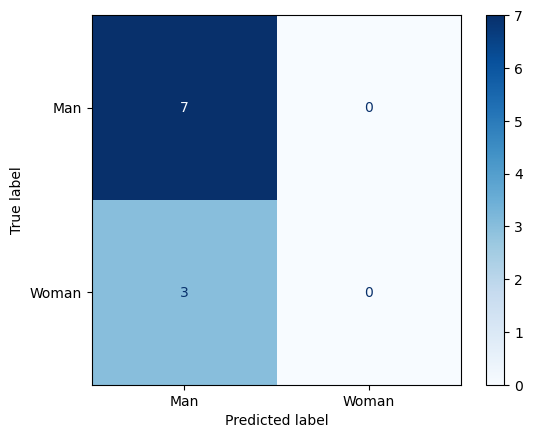

In [139]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display_labels = pandas_users.gender_true.drop_duplicates(keep='first', inplace=False).to_numpy()
cm = confusion_matrix(pandas_users.gender_true, pandas_users.gender_generated,labels=display_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels,)
disp.plot(cmap="Blues")
disp.figure_.savefig(evaluation_results_folder + "/gender_cm.png",dpi=300)

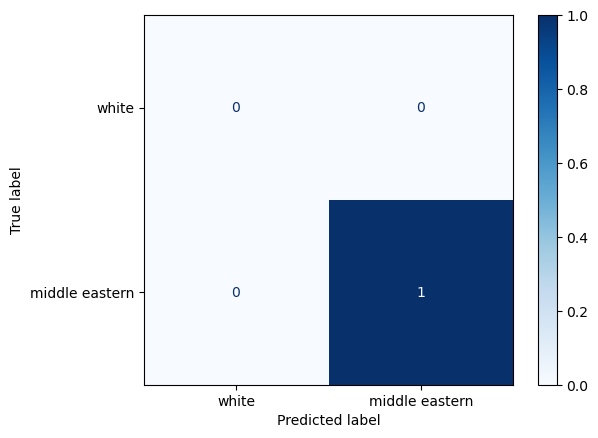

In [140]:
display_labels = pandas_users.ethnicity_true.drop_duplicates(keep='first', inplace=False).to_numpy()
cm = confusion_matrix(pandas_users.ethnicity_true, pandas_users.ethnicity_generated, labels=display_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp.plot(cmap="Blues")
disp.figure_.savefig(evaluation_results_folder + "/ethnicity_cm.png",dpi=300)

In [141]:
pandas_users

,id_true,user,age_true,age_generated,gender_true,gender_generated,ethnicity_true,ethnicity_generated
0,0,id00017,29.0,34.0,Man,Man,white,asian
1,183,id00061,32.0,35.0,Man,Man,middle eastern,asian
2,471,id00081,37.0,36.0,Man,Man,middle eastern,middle eastern
3,780,id00154,31.0,37.0,Man,Man,middle eastern,asian
4,968,id00419,38.0,36.0,Woman,Man,white,asian
5,1468,id00812,32.0,36.0,Woman,Man,white,asian
6,1875,id00817,31.0,36.0,Man,Man,white,asian
7,2328,id00866,26.0,34.0,Man,Man,white,asian
8,2600,id00926,42.0,33.0,Man,Man,white,asian
9,2763,id01000,30.0,31.0,Woman,Man,white,asian


In [142]:
f.close()

In [35]:
#https://pypi.org/project/pytorch-fid-wrapper/
#https://github.com/mseitzer/pytorch-fid

import  pytorch_fid_wrapper as pfw
import torchvision.datasets as datasets

data = datasets.ImageFolder(datasetPathGeneratedFaces)



